In [48]:
import sys
from datetime import datetime, timezone, timedelta

import pandas as pd
from sb3_contrib import TRPO
from stable_baselines3 import DQN, PPO, A2C 
from sklearn import metrics
from matplotlib import pyplot as plt

sys.path.append("../airflow/plugins")

from db_connection import DbConnection
from domain_model import Instrument, Interval
from gym_env_single_asset import register_single_asset_trading_env, Actions, SingleAssetTrading
from candles_sql_adapter import CandlesSqlAdapter
from strategy_sb3 import StrategySb3
from evaluation.strategy_evaluator import StrategyEvaluator

In [49]:
register_single_asset_trading_env(1)
db_connection = DbConnection.local_db_connection()
instrument = Instrument.get_instrument("SBER")
interval = Interval.hour_1

In [50]:
sql_adapter = CandlesSqlAdapter(db_connection, interval, instrument)
end_time_utc = datetime(2024, 12, 5, tzinfo=timezone.utc)
start_time_utc = end_time_utc - timedelta(days=60)
commission = 0.0

In [51]:
model = A2C.load("models/a2c_model.zip")
strategy = StrategySb3(model)
evaluator = StrategyEvaluator(sql_adapter, strategy)
a2c_df = evaluator.evaluate(start_time_utc, end_time_utc, commission)

In [52]:
model = PPO.load("models/ppo_model.zip")
strategy = StrategySb3(model)
evaluator = StrategyEvaluator(sql_adapter, strategy)
ppo_df = evaluator.evaluate(start_time_utc, end_time_utc, commission)

In [53]:
model = DQN.load("models/dqn_model.zip")
strategy = StrategySb3(model)
evaluator = StrategyEvaluator(sql_adapter, strategy)
dqn_df = evaluator.evaluate(start_time_utc, end_time_utc, commission)

In [54]:
model = TRPO.load("models/trpo_model.zip")
strategy = StrategySb3(model)
evaluator = StrategyEvaluator(sql_adapter, strategy)
trpo_df = evaluator.evaluate(start_time_utc, end_time_utc, commission)

<Axes: title={'center': 'DRL algo profit comparison (%) in 60 days SBER'}, xlabel='time_utc'>

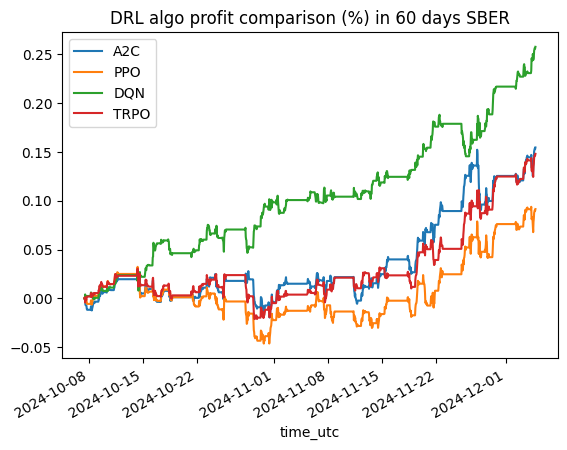

In [55]:
a2c_df.rename(columns={'profit_percent_cum_with_comission': 'A2C'}, inplace=True)
a2c_profit = a2c_df[['A2C']]

ppo_df.rename(columns={'profit_percent_cum_with_comission': 'PPO'}, inplace=True)
ppo_profit = ppo_df[['PPO']]

dqn_df.rename(columns={'profit_percent_cum_with_comission': 'DQN'}, inplace=True)
dqn_profit = dqn_df[['DQN']]

trpo_df.rename(columns={'profit_percent_cum_with_comission': 'TRPO'}, inplace=True)
trpo_profit = trpo_df[['TRPO']]

benchmark = a2c_profit.join([ppo_profit, dqn_profit, trpo_profit], sort=True)
benchmark.plot(title="DRL algo profit comparison (%) in 60 days SBER")


In [59]:
a2c_df = a2c_df.query('action_actual != 0 and action_pred != 0')
a2c_accuracy = metrics.accuracy_score(a2c_df["action_actual"], a2c_df["action_pred"])
a2c_f1 = metrics.f1_score(a2c_df["action_actual"], a2c_df["action_pred"])

ppo_df = ppo_df.query('action_actual != 0 and action_pred != 0')
ppo_accuracy = metrics.accuracy_score(ppo_df["action_actual"], ppo_df["action_pred"])
ppo_f1 = metrics.f1_score(ppo_df["action_actual"], ppo_df["action_pred"])

dqn_df = dqn_df.query('action_actual != 0 and action_pred != 0')
dqn_accuracy = metrics.accuracy_score(dqn_df["action_actual"], dqn_df["action_pred"])
dqn_f1 = metrics.f1_score(dqn_df["action_actual"], dqn_df["action_pred"])

trpo_df = trpo_df.query('action_actual != 0 and action_pred != 0')
trpo_accuracy = metrics.accuracy_score(trpo_df["action_actual"], trpo_df["action_pred"])
trpo_f1 = metrics.f1_score(trpo_df["action_actual"], trpo_df["action_pred"])

algo_metrics = {
    'A2C': [a2c_accuracy, a2c_f1],
    'PPO': [ppo_accuracy, ppo_f1],
    'DQN': [dqn_accuracy, dqn_f1],
    'TRPO': [trpo_accuracy, trpo_f1],
}

metrics_df = pd.DataFrame.from_dict(algo_metrics, orient='index', columns=['accuracy', 'f1'])
metrics_df


,accuracy,f1
A2C,0.541596,0.599407
PPO,0.538200,0.589124
DQN,0.546720,0.574627
TRPO,0.549618,0.627760


In [60]:
cm_a2c = metrics.confusion_matrix(a2c_df["action_actual"], a2c_df["action_pred"])
a2c_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_a2c, display_labels = ['Sell', 'Buy'])

cm_ppo = metrics.confusion_matrix(ppo_df["action_actual"], ppo_df["action_pred"])
ppo_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_ppo, display_labels = ['Sell', 'Buy'])

cm_dqn = metrics.confusion_matrix(dqn_df["action_actual"], dqn_df["action_pred"])
dqn_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_dqn, display_labels = ['Sell', 'Buy'])

cm_trpo = metrics.confusion_matrix(trpo_df["action_actual"], trpo_df["action_pred"])
trpo_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_trpo, display_labels = ['Sell', 'Buy'])

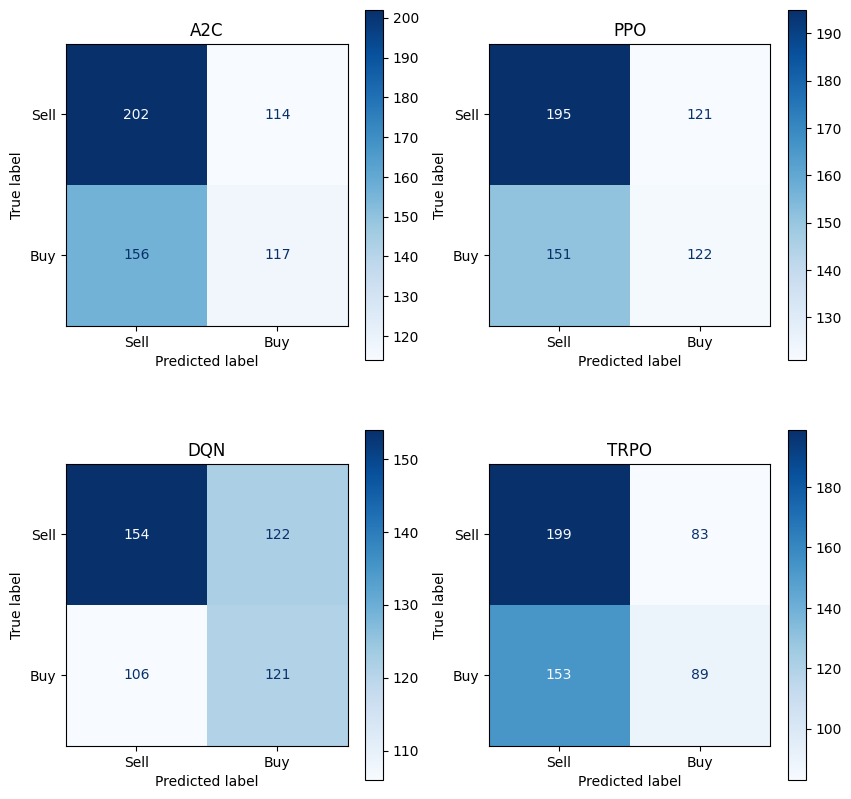

In [62]:
figure, axis = plt.subplots(2, 2, figsize = (10, 10))

a2c_display.plot(ax=axis[0, 0], cmap='Blues')
axis[0, 0].set_title("A2C")

ppo_display.plot(ax=axis[0, 1], cmap='Blues')
axis[0, 1].set_title("PPO")

dqn_display.plot(ax=axis[1, 0], cmap='Blues')
axis[1, 0].set_title("DQN")

trpo_display.plot(ax=axis[1, 1], cmap='Blues')
axis[1, 1].set_title("TRPO")

plt.show()